In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

from keras.utils import np_utils
from matplotlib import pyplot as plt
import os
import random
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# **LOAD DATA**

In [ ]:
#@title
import tensorflow as tf
# Load the video file
import cv2

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(200, activation='softmax')
])


In [ ]:
#@title
from keras.layers import Input, Conv2D, concatenate, Dense, UpSampling2D
from keras.models import Model
import tensorflow as tf
# Input layer for RGB image
rgb_input = Input(shape=(224, 224, 3))

# Convolutional layers for RGB image
rgb_conv1 = Conv2D(32, 3, activation='relu', padding = 'same')(rgb_input)
rgb_pool1 = MaxPooling2D(2)(rgb_conv1)
rgb_conv2 = Conv2D(64, 3, activation="relu", padding='same')(rgb_pool1)
rgb_pool2 = MaxPooling2D(2)(rgb_conv1)




# Concatenate the output of the two streams
merged = rgb_pool2

merged = Flatten()(merged)
# Final dense layer for classification
fcn1 = Dense(512, activation="relu")(merged)
output = Dense(200, activation='softmax')(fcn1)

# Create the model
model = Model(inputs=[rgb_input], outputs=output)


In [3]:
import os
import numpy as np
dirs = os.listdir('drive/My Drive')

def get_label(sub):
  gt = os.path.join(f'drive/My Drive/subject{sub}/ground_truth.txt')
  gtfilename = gt
  gtdata = np.loadtxt(gtfilename)
  gtTrace = gtdata[0,:].T
  gtTime = gtdata[2,:].T
  gtHR = gtdata[1,:].T
  return gtHR

def get_data(sub, off):
    images = []
    labels = []
  
    cap = cv2.VideoCapture(f"drive/My Drive/subject{sub}/vid.avi")
    # Loop through the video frames
    
    X_video = np.zeros((100, 64, 64, 3), dtype=np.uint8)
    y_video = np.zeros((100, 1))
    labels = get_label(sub)
    for i in range(off*100):
        ret, frame = cap.read()
    for i in range(100):
        ret, frame = cap.read()
        if ret == True:
            frame = cv2.resize(frame, (64,64))
            X_video[i, :, :, :] = frame
            y_video[i, 0] = labels[off*100+i]
        else:
          break
    return X_video, y_video
import pandas as pd
def DenseToSparse(labels):
    labels = pd.Series(labels).apply(lambda c:(int)(c))
    labels = labels.astype(np.ubyte)
    sparse_labels = np.zeros((labels.shape[0],150))
    sparse_labels[labels.index,labels] = 1
    return sparse_labels


In [4]:
images = []
labels = []
i=0
for sub in range(50):
    print("counter: ", sub)
    if(dirs.count(f'subject{sub}')==0):
      print(sub)
      continue
    for off in range(12):  
      img, label = get_data(sub, off)
      images.append(img)
      labels.append(label)
sparse_labels = DenseToSparse(labels)

counter:  0
0
counter:  1


KeyboardInterrupt: ignored

In [3]:
np.save('data_hr.npy', images)
np.save('labels_hr.npy', labels)

NameError: ignored

In [4]:
images = np.load('drive/My Drive/hr_data/data_hr.npy')
labels = np.load('drive/My Drive/hr_data/labels_hr.npy')

In [5]:
images = np.array(images)
#labels = np.array(labels)

In [7]:
print(images.shape)

(480, 100, 64, 64, 3)


# **BUILD MODEL**

In [ ]:
#@title
split = int(0.85* images.shape[0])
X_train = images[:split, :, :, :, np.newaxis]
y_train = labels[:split, :]
X_test = images[split:, :, :, :, np.newaxis]
y_test = labels[split:, :]

In [ ]:
#@title
import tensorflow as tf
# Load the video file
import cv2

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(200, activation='softmax')
])


In [6]:
import tensorflow as tf
def create_model():
  # Define the model
  model = tf.keras.Sequential()

  # 1st Conv3D layer
  model.add(tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', 
                                  input_shape=(100, 64, 64, 3)))
  model.add(tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2)))

  # 2nd Conv3D layer
  model.add(tf.keras.layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPool3D(pool_size=(2, 2, 2)))

  # Flatten the output from the Conv3D layers
  model.add(tf.keras.layers.Flatten())

  # Add a fully connected layer
  model.add(tf.keras.layers.Dense(128, activation='relu'))

  # Add the output layer
  model.add(tf.keras.layers.Dense(1, activation='linear'))
  return model

models = [create_model() for i in range(5)]

# Compile the models
for model in models:
  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])



In [6]:
from keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense
from keras.models import Model

# First 3D CNN model
input1 = Input(shape=(100, 64, 64, 3))
x1 = Conv3D(32, (3, 3, 3), activation='relu')(input1)
x1 = MaxPooling3D(pool_size=(2, 2, 2))(x1)
x1 = Conv3D(64, (3, 3, 3), activation='relu')(x1)
x1 = MaxPooling3D(pool_size=(2, 2, 2))(x1)
x1 = Flatten()(x1)
x1 = Dense(128, activation='relu')(x1)
output1 = Dense(1, activation='linear')(x1)

model1 = Model(inputs=input1, outputs=output1)
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Second 3D CNN model
input2 = Input(shape=(100, 64, 64, 3))
x2 = Conv3D(32, (3,3,3), activation='relu')(input2)
x2 = MaxPooling3D(pool_size=(2, 2, 2))(x2)
x2 = Conv3D(64, (3,3,3), activation='relu')(x2)
x2 = MaxPooling3D(pool_size=(2, 2, 2))(x2)
x2 = Conv3D(64, (3,3,3), activation='relu')(x2)
x2 = MaxPooling3D(pool_size=(2, 2, 2))(x2)
x2 = Flatten()(x2)
x2 = Dense(256, activation='relu')(x2)
output2 = Dense(1, activation='linear')(x2)

model2 = Model(inputs=input2, outputs=output2)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Third 3D CNN model
input3 = Input(shape=(100, 64, 64, 3))
x3 = Conv3D(32, (3,3,3), activation='relu')(input3)
x3 = MaxPooling3D(pool_size=(2, 2, 2))(x3)
x3 = Conv3D(64, (3,3,3), activation='relu')(x3)
x3 = MaxPooling3D(pool_size=(2, 2, 2))(x3)
x3 = Flatten()(x3)
x3 = Dense(256, activation='relu')(x3)
output3 = Dense(1, activation='linear')(x3)

model3 = Model(inputs=input3, outputs=output3)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])



In [7]:
models = [model1, model2, model3]

In [12]:
print(y_train.shape)

(432, 100, 1)


In [10]:
print(len(models))

5


# **SPLIT DATA AND TRAIN MODEL**

In [ ]:
#@title
import numpy as np

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[5]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], X_test.shape[5]))


In [8]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=0, shuffle=True)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.20) # , random_state=40, shuffle=True)

In [9]:
histories = []
for model in models:
    history = model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid), batch_size = 8)
    histories.append(history)

Epoch 1/100
54/54 [==============================] - 16s 170ms/step - loss: 3004426.7500 - mae: 339.4279 - val_loss: 592.9012 - val_mae: 20.4900
Epoch 2/100
54/54 [==============================] - 8s 153ms/step - loss: 448.6316 - mae: 14.8563 - val_loss: 697.1804 - val_mae: 22.8634
Epoch 3/100
54/54 [==============================] - 8s 155ms/step - loss: 379.4343 - mae: 13.4766 - val_loss: 215.7850 - val_mae: 9.6088
Epoch 4/100
54/54 [==============================] - 9s 159ms/step - loss: 301.0859 - mae: 11.3681 - val_loss: 253.5720 - val_mae: 9.2494
Epoch 5/100
54/54 [==============================] - 8s 157ms/step - loss: 417.4250 - mae: 14.5350 - val_loss: 500.5498 - val_mae: 14.8809
Epoch 6/100
54/54 [==============================] - 8s 155ms/step - loss: 401.9353 - mae: 14.2030 - val_loss: 274.7891 - val_mae: 9.6569
Epoch 7/100
54/54 [==============================] - 8s 156ms/step - loss: 301.9638 - mae: 12.5089 - val_loss: 220.1074 - val_mae: 8.4070
Epoch 8/100
54/54 [======

NameError: ignored

In [10]:
from keras.layers import Average

ensemble_input = Input(shape=(100, 64, 64, 3))
model1_output = model1(ensemble_input)
model2_output = model2(ensemble_input)
model3_output = model3(ensemble_input)

# Average the outputs from the individual models
ensemble_output = Average()([model1_output, model2_output, model3_output])

# Create the ensemble model
ensemble_model = Model(inputs=ensemble_input, outputs=ensemble_output)
ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
#@title
import tensorflow as tf

class ResidualFCN(tf.keras.Model):
    def __init__(self, num_classes=200):
        super(ResidualFCN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')
        self.residual = tf.keras.layers.Conv2D(64, 1, activation='relu', padding='same')
        self.pool = tf.keras.layers.MaxPool2D()
        self.upsample = tf.keras.layers.UpSampling2D()
        self.conv3 = tf.keras.layers.Conv2D(num_classes, 3, activation='relu', padding='same')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        r = self.residual(inputs)
        x = tf.keras.layers.add([x, r])
        x = self.pool(x)
        x = self.upsample(x)
        x = self.conv3(x)
        return x

model = ResidualFCN()


In [ ]:
#@title
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#@title
import tensorflow as tf

# Load the pre-trained model
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

# Freeze the model layers
for layer in model.layers:
    layer.trainable = False

# Add a new classification head
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(200, activation='softmax')(x)

# Create the final model
model = tf.keras.models.Model(inputs=model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
ensemble_model.evaluate(x_test, y_test, batch_size=1)

10/10 [==============================] - 1s 22ms/step - loss: 16.0731 - mae: 3.3199


[16.073055267333984, 3.3199429512023926]

In [12]:
ensemble_model.evaluate(x_train, y_train, batch_size=1)

432/432 [==============================] - 8s 19ms/step - loss: 32.3600 - mae: 2.7948


[32.35999298095703, 2.7947604656219482]

In [13]:
ensemble_model.evaluate(x_valid, y_valid, batch_size=1)

38/38 [==============================] - 1s 20ms/step - loss: 143.3835 - mae: 4.3930


[143.38345336914062, 4.392992973327637]

In [14]:
ensemble_model.save('/content/weights.h5')

In [ ]:
print(x_train[0][1].shape)

(64, 64, 3)


# **OCCLUSION MAPS**

Streaming output truncated to the last 5000 lines.
90.994835
1/1 [==============================] - 0s 23ms/step
80.27202
1/1 [==============================] - 0s 22ms/step
90.7915
1/1 [==============================] - 0s 20ms/step
87.29222
1/1 [==============================] - 0s 22ms/step
89.36657
1/1 [==============================] - 0s 19ms/step
86.41974
1/1 [==============================] - 0s 23ms/step
91.21459
1/1 [==============================] - 0s 26ms/step
82.630455
1/1 [==============================] - 0s 21ms/step
84.33416
1/1 [==============================] - 0s 27ms/step
80.17082
1/1 [==============================] - 0s 24ms/step
83.56348
1/1 [==============================] - 0s 22ms/step
77.52053
1/1 [==============================] - 0s 27ms/step
77.69094
1/1 [==============================] - 0s 25ms/step
73.75706
1/1 [==============================] - 0s 20ms/step
77.451096
1/1 [==============================] - 0s 24ms/step
75.30344
1/1 [==================

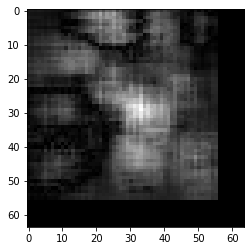

In [21]:
def generate_occlusion_map(input_tensor, model, patch_size, label):
    input_shape = input_tensor.shape
    print(input_shape)
    occlusion_map = np.zeros(input_shape[1:])
    for i in range(input_shape[1] - patch_size[0]):
        for j in range(input_shape[2] - patch_size[1]):
            for k in range(input_shape[3] - patch_size[2]):
                occlusion = input_tensor.copy()
                occlusion[:, i:i+patch_size[0], j:j+patch_size[1], k:k+patch_size[2]] = 0
                prediction = model.predict(occlusion[np.newaxis, ...])
                print(prediction[0][0])
                diff = abs(prediction[0][0]-label)
                occlusion_map[i, j, k] = diff
    return occlusion_map

# Use the function to generate an occlusion map
print(y_train[0][0][0])
occlusion_map = generate_occlusion_map(x_train[0], ensemble_model, (8, 8, 1), y_train[0][0][0])
import matplotlib.pyplot as plt
print(occlusion_map.shape)
plt.imshow(occlusion_map[:,:,0], cmap='gray')
plt.show()


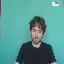

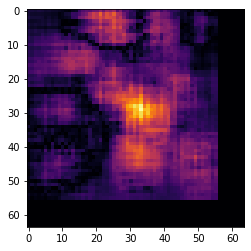

In [25]:
from google.colab.patches import cv2_imshow
cv2_imshow(x_train[0][0])
plt.imshow(occlusion_map[:,:,0], cmap = 'inferno')
plt.show()

In [ ]:
#@title
save_path = '/content/model2.h5'
try:
    history = model.fit(x_train, y_train, epochs=200, validation_data=(x_valid, y_valid), batch_size = 32)
except KeyboardInterrupt:
    model.save(save_path)
    print('Output saved to: "{}./*"'.format(save_path))

Epoch 1/200
14/14 [==============================] - 8s 556ms/step - loss: 40.1959 - mae: 3.1708 - val_loss: 203.5518 - val_mae: 6.7812
Epoch 2/200
14/14 [==============================] - 7s 528ms/step - loss: 41.7486 - mae: 3.3686 - val_loss: 178.8839 - val_mae: 6.5460
Epoch 3/200
14/14 [==============================] - 7s 536ms/step - loss: 37.4592 - mae: 3.0611 - val_loss: 188.1512 - val_mae: 6.6112
Epoch 4/200
14/14 [==============================] - 8s 546ms/step - loss: 38.4439 - mae: 3.0862 - val_loss: 179.1144 - val_mae: 6.6803
Epoch 5/200
14/14 [==============================] - 8s 546ms/step - loss: 37.7687 - mae: 3.0650 - val_loss: 187.8531 - val_mae: 7.2338
Epoch 6/200
14/14 [==============================] - 7s 530ms/step - loss: 38.1301 - mae: 3.2977 - val_loss: 179.5939 - val_mae: 6.7879
Epoch 7/200
14/14 [==============================] - 7s 530ms/step - loss: 38.3004 - mae: 3.1619 - val_loss: 201.2158 - val_mae: 6.8696
Epoch 8/200
14/14 [=============================

# **PLOTS**

In [ ]:
model.save('/content/model_hr.h5')

In [18]:
np.save('hist.npy', histories)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......conv3d
.........vars
............0
............1
......conv3d_1
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......flatten
.........vars
......input_layer
.........vars
......max_pooling3d
.........vars
......max_pooling3d_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
metadata.json                                  2023-02-28 10:30:26           64
config.json               

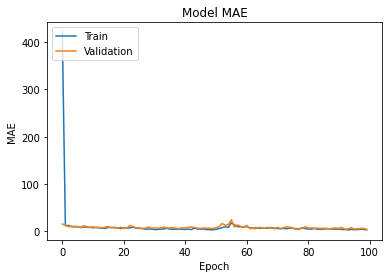

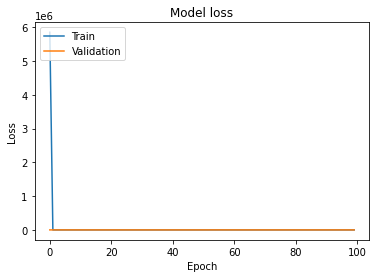

In [16]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(histories[2].history['mae'])
plt.plot(histories[2].history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(histories[2].history['loss'])
plt.plot(histories[2].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

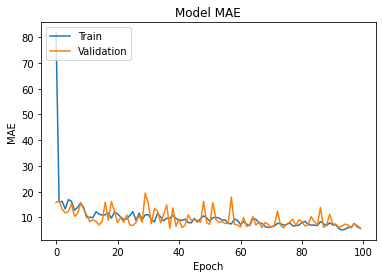

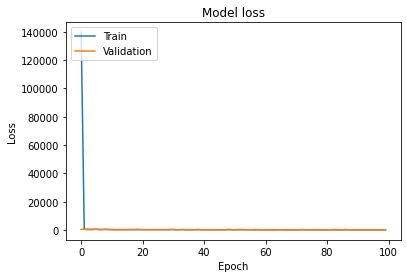

In [19]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(histories[1].history['mae'])
plt.plot(histories[1].history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(histories[1].history['loss'])
plt.plot(histories[1].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Counterfeit Data Augmentation**

In [32]:
from keras.preprocessing.image import ImageDataGenerator
import os

# Define directories for original and counterfeit data
original_dir = 'path/to/original/data'
counterfeit_dir = 'path/to/counterfeit/data'

# Define image data generator for counterfeit data
datagen = ImageDataGenerator(
    brightness_range=[0.7, 1.3],
    channel_shift_range=50,
    # Add more parameters to vary the background
    fill_mode='constant', # Fill with constant value instead of nearest pixel
    cval=255, # Set constant value to white
)


# Load original image
c = []
for cnt in range(10):
  c.append([]);
num = 0
clab = []
for img in x_train[0]:
  img1 = img.reshape((1,) + img.shape)
  # Generate 10 counterfeit images
  i = 0
  label = y_train[0][num]
  for batch in datagen.flow(img1, batch_size=1):
      c[i].append(batch[0])
      i += 1
      if i > 9:
          break
  num+=1

In [34]:
c = np.array(c)
print(c.shape)

(10, 100, 64, 64, 3)


Streaming output truncated to the last 5000 lines.
115.05986
1/1 [==============================] - 0s 26ms/step
108.35564
1/1 [==============================] - 0s 27ms/step
114.882324
1/1 [==============================] - 0s 26ms/step
112.92973
1/1 [==============================] - 0s 26ms/step
112.399796
1/1 [==============================] - 0s 26ms/step
112.8973
1/1 [==============================] - 0s 34ms/step
115.06921
1/1 [==============================] - 0s 26ms/step
109.122665
1/1 [==============================] - 0s 25ms/step
107.988235
1/1 [==============================] - 0s 30ms/step
107.560425
1/1 [==============================] - 0s 33ms/step
107.70938
1/1 [==============================] - 0s 29ms/step
103.90018
1/1 [==============================] - 0s 28ms/step
101.71813
1/1 [==============================] - 0s 26ms/step
99.37891
1/1 [==============================] - 0s 27ms/step
101.275116
1/1 [==============================] - 0s 29ms/step
101.25496
1/1 [

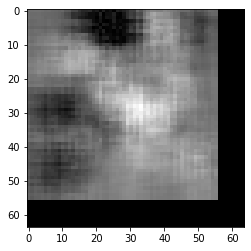

In [35]:
occlusion_map = generate_occlusion_map(c[0], ensemble_model, (8, 8, 1), y_train[0][0][0])
import matplotlib.pyplot as plt
print(occlusion_map.shape)
plt.imshow(occlusion_map[:,:,0], cmap='gray')
plt.show()

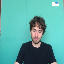

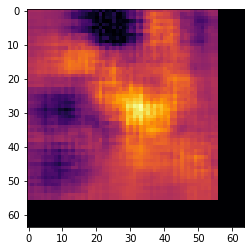

In [37]:
cv2_imshow(c[0][0])
plt.imshow(occlusion_map[:,:,0], cmap='inferno')
plt.show()

# **COMPARING OCCLUSION MAPS THROUGH IOU**

# **GENERATING COUNTERFIET DATA FOR ENTIRE DATA**

# **TRAINING MODEL ON ORIGINAL+SYNTHETIC DATA**

# **GENERATE ENSEMBLE MODEL BY WEIGHING ALL MODELS BY THE OCCLUSION MAPS**
To modify the code to average models weighed by XAI occlusion maps, we need to first generate the occlusion maps for each of the individual models. Then, we can use the occlusion maps to assign weights to each of the models based on their performance on the most important parts of the input data. The idea is that models that are more confident and consistent in their predictions on the most important parts of the input data should be given more weight. In this way, the ensemble model can take advantage of the strengths of each individual model in the group, while minimizing the impact of any weaknesses.